In [ ]:
!pip install -q kaggle

from google.colab import files
import os

uploaded = files.upload()
os.makedirs("/root/.kaggle", exist_ok=True)
with open("/root/.kaggle/kaggle.json", "wb") as f:
    f.write(uploaded["kaggle.json"])
os.chmod("/root/.kaggle/kaggle.json", 600)

!kaggle datasets download -d nih-chest-xrays/data -f Data_Entry_2017.csv --force
!kaggle datasets download -d nih-chest-xrays/data -f train_val_list.txt --force
!kaggle datasets download -d nih-chest-xrays/data -f test_list.txt --force

!ls -lh Data_Entry_2017.csv train_val_list.txt test_list.txt

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/nih-chest-xrays/data
License(s): CC0-1.0
  0% 0.00/924k [00:00<?, ?B/s]
100% 924k/924k [00:00<00:00, 1.22GB/s]
Dataset URL: https://www.kaggle.com/datasets/nih-chest-xrays/data
License(s): CC0-1.0
  0% 0.00/199k [00:00<?, ?B/s]
100% 199k/199k [00:00<00:00, 581MB/s]
Dataset URL: https://www.kaggle.com/datasets/nih-chest-xrays/data
License(s): CC0-1.0
  0% 0.00/425k [00:00<?, ?B/s]
100% 425k/425k [00:00<00:00, 956MB/s]
-rw-r--r-- 1 root root 925K Sep 25  2019 Data_Entry_2017.csv
-rw-r--r-- 1 root root 425K Sep 25  2019 test_list.txt
-rw-r--r-- 1 root root 200K Sep 25  2019 train_val_list.txt


In [ ]:
!mv Data_Entry_2017.csv Data_Entry_2017.zip
!unzip -o Data_Entry_2017.zip

!mv train_val_list.txt train_val_list.zip
!unzip -o train_val_list.zip

Archive:  Data_Entry_2017.zip
  inflating: Data_Entry_2017.csv     
Archive:  train_val_list.zip
  inflating: train_val_list.txt      


In [ ]:
import pandas as pd

csv_path = "/content/Data_Entry_2017.csv"

df = pd.read_csv(csv_path, sep=",", engine="python")

df = df.drop(columns=["Unnamed: 11"], errors='ignore')

df.columns = [
    "Image Index", "Finding Labels", "Follow-up #", "Patient ID",
    "Patient Age", "Patient Gender", "View Position",
    "Image Width", "Image Height", "Pixel Spacing X", "Pixel Spacing Y"
]

print("📋 Veri kümesinin ilk 5 satırı:")
print(df.head())

📋 Veri kümesinin ilk 5 satırı:
        Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   
3  00000002_000.png              No Finding            0           2   
4  00000003_000.png                  Hernia            0           3   

   Patient Age Patient Gender View Position  Image Width  Image Height  \
0           58              M            PA         2682          2749   
1           58              M            PA         2894          2729   
2           58              M            PA         2500          2048   
3           81              M            PA         2500          2048   
4           81              F            PA         2582          2991   

   Pixel Spacing X  Pixel Spacing Y  
0            0.143            0.143  
1            0.

In [ ]:
import pandas as pd
import os

csv_path = "/content/Data_Entry_2017.csv"
df = pd.read_csv(csv_path)

print(f"Toplam görüntü sayısı: {len(df)}")
df.head()

Toplam görüntü sayısı: 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [ ]:
# Çoklu etiketleri ayır
df["Finding Labels"] = df["Finding Labels"].str.split("|")

# "No Finding" olanları filtrele
no_finding_df = df[df["Finding Labels"].apply(lambda x: len(x) == 1 and x[0] == "No Finding")]
rest_df = df[df["Finding Labels"].apply(lambda x: not (len(x) == 1 and x[0] == "No Finding"))]

print(f'"No Finding" örnek sayısı (çıkarılacak): {len(no_finding_df)}')

"No Finding" örnek sayısı (çıkarılacak): 60361


In [ ]:
from collections import defaultdict, Counter
import pandas as pd

target_count = 600
label_to_images = defaultdict(list)

# Görsellerin etiketlerine göre satır index'lerini topluyoruz
for idx, labels in df.iterrows():
    for label in labels["Finding Labels"]:
        label_to_images[label].append(idx)

# Her sınıftan hedef sayıda örnek seçiyoruz
selected_indices = set()

for label, indices in label_to_images.items():
    if label == "No Finding":
        limit = target_count * 3  # No Finding için 3 katı
    else:
        limit = target_count

    sampled = indices if len(indices) <= limit else pd.Series(indices).sample(limit, random_state=42).tolist()
    selected_indices.update(sampled)

# Seçilen satırlardan df_filtered oluştur (görsel bazında tekilleştirerek)
df_filtered = df.loc[list(selected_indices)].drop_duplicates(subset=["Image Index"]).reset_index(drop=True)

# Kontrol için etiket dağılımı
label_counts = Counter()
for labels in df_filtered["Finding Labels"]:
    label_counts.update(labels)

label_distribution = pd.DataFrame(label_counts.items(), columns=["Label", "Count"]).sort_values("Count", ascending=False)
print(label_distribution)

                 Label  Count
3         Infiltration   2327
10            Effusion   2056
6           No Finding   1800
8          Atelectasis   1658
12                Mass   1148
13              Nodule   1103
1         Pneumothorax   1039
4        Consolidation   1012
11  Pleural_Thickening    934
9                Edema    835
0            Emphysema    780
7         Cardiomegaly    761
5            Pneumonia    718
14            Fibrosis    679
2               Hernia    227


In [ ]:
from collections import Counter

label_counter = Counter()
for labels in df_filtered["Finding Labels"]:
    label_counter.update(labels)

label_distribution = pd.DataFrame(label_counter.items(), columns=["Label", "Count"]).sort_values("Count", ascending=False)
label_distribution

,Label,Count
3,Infiltration,2327
10,Effusion,2056
6,No Finding,1800
8,Atelectasis,1658
12,Mass,1148
13,Nodule,1103
1,Pneumothorax,1039
4,Consolidation,1012
11,Pleural_Thickening,934
9,Edema,835


In [ ]:
rare_labels = label_distribution[label_distribution["Count"] < 500]["Label"].tolist()

print("Nadir sınıflar (<1000 örnek):", rare_labels)

def remove_rare_labels(row):
    return [label for label in row if label not in rare_labels]

# Nadiren görülenleri çıkar
df_filtered["Finding Labels"] = df_filtered["Finding Labels"].apply(remove_rare_labels)

# Tamamen etiketsiz kalanları çıkar
df_filtered = df_filtered[df_filtered["Finding Labels"].map(len) > 0]

print(f"Nadir hastalıklar elendikten sonra kalan veri sayısı: {len(df_filtered)}")

Nadir sınıflar (<1000 örnek): ['Hernia']
Nadir hastalıklar elendikten sonra kalan veri sayısı: 9310


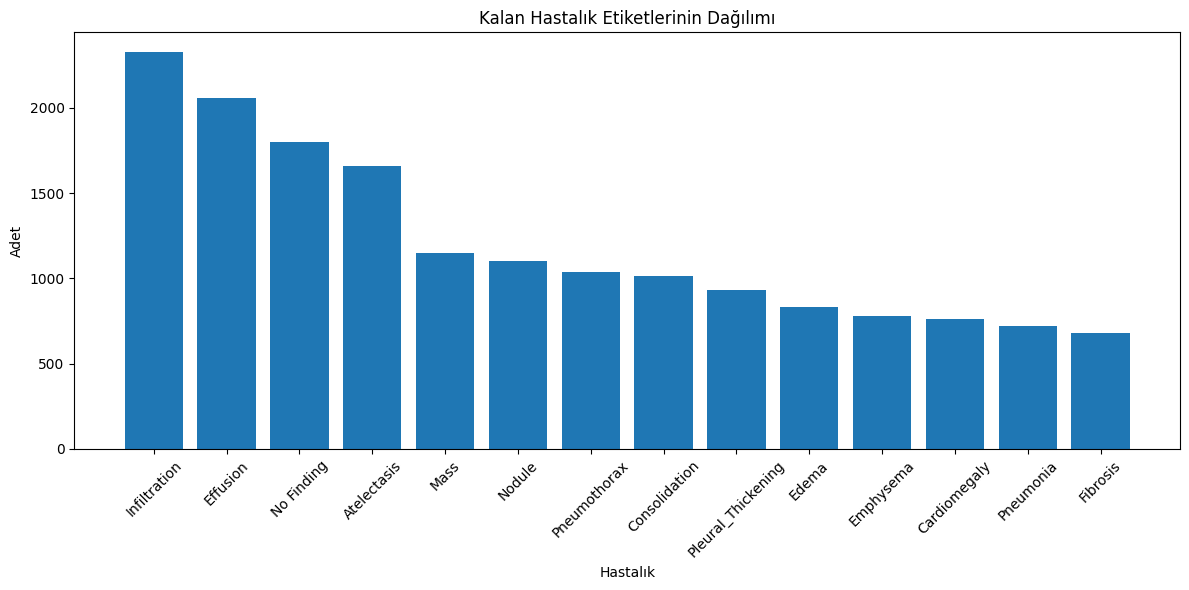

In [ ]:
label_counter_updated = Counter()
for labels in df_filtered["Finding Labels"]:
    label_counter_updated.update(labels)

updated_distribution = pd.DataFrame(label_counter_updated.items(), columns=["Label", "Count"]).sort_values("Count", ascending=False)

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(updated_distribution["Label"], updated_distribution["Count"])
plt.xticks(rotation=45)
plt.title("Kalan Hastalık Etiketlerinin Dağılımı")
plt.xlabel("Hastalık")
plt.ylabel("Adet")
plt.tight_layout()
plt.show()

#downloading dataset

In [ ]:
import os
import tarfile
import requests
from tqdm import tqdm

In [ ]:
# image arşivlerinin url'leri
url_map = {
    'images_01.tar.gz': 'https://nihcc.box.com/shared/static/vfk49d74nhbxq3nqjg0900w5nvkorp5c.gz',
    'images_02.tar.gz': 'https://nihcc.box.com/shared/static/i28rlmbvmfjbl8p2n3ril0pptcmcu9d1.gz',
    'images_03.tar.gz': 'https://nihcc.box.com/shared/static/f1t00wrtdk94satdfb9olcolqx20z2jp.gz',
    'images_04.tar.gz': 'https://nihcc.box.com/shared/static/0aowwzs5lhjrceb3qp67ahp0rd1l1etg.gz',
    'images_05.tar.gz': 'https://nihcc.box.com/shared/static/v5e3goj22zr6h8tzualxfsqlqaygfbsn.gz',
    'images_06.tar.gz': 'https://nihcc.box.com/shared/static/asi7ikud9jwnkrnkj99jnpfkjdes7l6l.gz',
    'images_07.tar.gz': 'https://nihcc.box.com/shared/static/jn1b4mw4n6lnh74ovmcjb8y48h8xj07n.gz',
    'images_08.tar.gz': 'https://nihcc.box.com/shared/static/tvpxmn7qyrgl0w8wfh9kqfjskv6nmm1j.gz',
    'images_09.tar.gz': 'https://nihcc.box.com/shared/static/upyy3ml7qdumlgk2rfcvlb9k6gvqq2pj.gz',
    'images_10.tar.gz': 'https://nihcc.box.com/shared/static/l6nilvfa9cg3s28tqv1qc1olm3gnz54p.gz',
    'images_11.tar.gz': 'https://nihcc.box.com/shared/static/hhq8fkdgvcari67vfhs7ppg2w6ni4jze.gz',
    'images_12.tar.gz': 'https://nihcc.box.com/shared/static/ioqwiy20ihqwyr8pf4c24eazhh281pbu.gz'
}

In [ ]:
def download_file(url, dest_path):
    response = requests.get(url, stream=True)
    total = int(response.headers.get('content-length', 0))
    with open(dest_path, 'wb') as file, tqdm(
        desc=dest_path,
        total=total,
        unit='B',
        unit_scale=True,
        unit_divisor=1024
    ) as bar:
        for data in response.iter_content(chunk_size=1024):
            size = file.write(data)
            bar.update(size)

os.makedirs('/content/archives', exist_ok=True)

for filename, url in url_map.items():
    dest = f'/content/archives/{filename}'
    if not os.path.exists(dest):
        download_file(url, dest)

/content/archives/images_01.tar.gz: 100%|██████████| 1.87G/1.87G [01:57<00:00, 17.1MB/s]
/content/archives/images_02.tar.gz: 100%|██████████| 3.68G/3.68G [03:45<00:00, 17.6MB/s]
/content/archives/images_03.tar.gz: 100%|██████████| 3.66G/3.66G [03:49<00:00, 17.1MB/s]
/content/archives/images_04.tar.gz: 100%|██████████| 3.58G/3.58G [03:47<00:00, 16.9MB/s]
/content/archives/images_05.tar.gz: 100%|██████████| 3.67G/3.67G [03:42<00:00, 17.7MB/s]
/content/archives/images_06.tar.gz: 100%|██████████| 3.71G/3.71G [03:55<00:00, 16.9MB/s]
/content/archives/images_07.tar.gz: 100%|██████████| 3.74G/3.74G [03:49<00:00, 17.5MB/s]
/content/archives/images_08.tar.gz: 100%|██████████| 3.74G/3.74G [03:47<00:00, 17.6MB/s]
/content/archives/images_09.tar.gz: 100%|██████████| 3.83G/3.83G [03:51<00:00, 17.8MB/s]
/content/archives/images_10.tar.gz: 100%|██████████| 3.89G/3.89G [03:57<00:00, 17.6MB/s]
/content/archives/images_11.tar.gz: 100%|██████████| 3.90G/3.90G [04:08<00:00, 16.8MB/s]
/content/archives/ima

In [ ]:
extract_dir = "/content/extracted"
os.makedirs(extract_dir, exist_ok=True)

for archive in os.listdir("/content/archives"):
    archive_path = os.path.join("/content/archives", archive)
    with tarfile.open(archive_path, 'r:gz') as tar:
        tar.extractall(path=extract_dir)

In [ ]:
import os
import shutil
from tqdm import tqdm

# Görsel isimlerini normalize ediyoruz (boşlukları temizle)
image_names = set(df_filtered["Image Index"].str.strip())

source_dir = os.path.join(extract_dir, "images")
filtered_dir = "/content/filtered_images"
os.makedirs(filtered_dir, exist_ok=True)

extracted_images = os.listdir(source_dir)

copied = 0
not_found = 0

for name in tqdm(extracted_images):
    if name.strip() in image_names:
        shutil.copy(os.path.join(source_dir, name), os.path.join(filtered_dir, name))
        copied += 1
    else:
        not_found += 1

print(f"✅ {copied} dosya kopyalandı.")
print(f"⚠️  {not_found} dosya df_filtered içinde yoktu.")

# Ekstra güvenlik: df_filtered içindeki dosyalardan kaç tanesi kopyalanamadı?
missing_from_filtered = image_names.difference(set(extracted_images))
print(f"❌ df_filtered içinde olup bulunamayan dosya sayısı: {len(missing_from_filtered)}")

100%|██████████| 112120/112120 [00:27<00:00, 4054.05it/s]


✅ 9310 dosya kopyalandı.
⚠️  102810 dosya df_filtered içinde yoktu.
❌ df_filtered içinde olup bulunamayan dosya sayısı: 0


In [ ]:
import os

filtered_dir = "/content/filtered_images"

# Klasördeki dosya sayısını al
image_files = [f for f in os.listdir(filtered_dir) if os.path.isfile(os.path.join(filtered_dir, f))]
print(f"📁 filtered_images klasöründeki görsel sayısı: {len(image_files)}")

📁 filtered_images klasöründeki görsel sayısı: 9310


In [ ]:
import shutil

# Zip dosyasını oluştur
shutil.make_archive("/content/filtered_images", 'zip', "/content/filtered_images")

print("✅ filtered_images klasörü sıkıştırıldı: /content/filtered_images.zip")

KeyboardInterrupt: 

In [ ]:
import shutil

shutil.rmtree("/content/extracted")
shutil.rmtree("/content/archives")

print("Geçici dosyalar temizlendi.")


#hyperparameter optimization and model training

In [ ]:
from sklearn.model_selection import train_test_split

# 70% train, 15% val, 15% test
train_df, temp_df = train_test_split(df_filtered, test_size=0.3, random_state=42, shuffle=True)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, shuffle=True)

print(f"Train: {len(train_df)}\nVal: {len(val_df)}\nTest: {len(test_df)}")

Train: 6517
Val: 1396
Test: 1397


In [ ]:
import os
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
from torchvision.models import Inception_V3_Weights

# ImageNet normalizasyon değerleri (Inception için ideal)
inception_weights = Inception_V3_Weights.DEFAULT
inception_transforms = inception_weights.transforms()

transform = transforms.Compose([
    #for vgg19
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.ToTensor() #for vgg19

    #for densenet121
    #transforms.Resize((224, 224)),
    #transforms.RandomHorizontalFlip(p=0.5),
    #transforms.RandomRotation(degrees=5),
    #transforms.ColorJitter(brightness=0.1, contrast=0.1),
    #transforms.RandomAffine(degrees=0, translate=(0.02, 0.02)),
    #transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         #std=[0.229, 0.224, 0.225])

    #for CapsNet
    #transforms.Resize((64, 64)),  # daha büyük olursa decoder maliyeti artar
    #transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
    #transforms.ToTensor(),
    #transforms.Normalize(mean=[0.5], std=[0.5])  # grayscale için normalize (R=G=B)
])


test_transform = transforms.Compose([
    #for densenet121
    #transforms.Resize((224, 224)),
    #transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         #std=[0.229, 0.224, 0.225])

    #for CapsNet
    #transforms.Resize((64, 64)),
    #transforms.ToTensor(),
    #transforms.Normalize(mean=[0.5], std=[0.5])

    #for vgg19
    transforms.Resize((224, 224)),  # sabit boyuta ölçekle
    transforms.ToTensor(),          # tensöre çevir
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet istatistiklerine göre normalize
                         std=[0.229, 0.224, 0.225])
])

class ChestXrayDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform
        self.labels_list = sorted(list({label for sublist in dataframe["Finding Labels"] for label in sublist}))

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_path = os.path.join(self.image_dir, row["Image Index"])
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        labels = torch.zeros(len(self.labels_list))
        for label in row["Finding Labels"]:
            labels[self.labels_list.index(label)] = 1

        return image, labels

In [ ]:
import torch
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 16
VAL_BATCH_SIZE = 32
image_dir = "/content/filtered_images"

train_dataset = ChestXrayDataset(train_df, image_dir, transform)
val_dataset = ChestXrayDataset(val_df, image_dir, transform=test_transform)
test_dataset = ChestXrayDataset(test_df, image_dir, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=VAL_BATCH_SIZE, shuffle=False, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=VAL_BATCH_SIZE, shuffle=False, num_workers=8)

# ***DENSENET121***

In [ ]:
import torchvision.models as models
import torch.nn as nn

num_classes = len(train_dataset.labels_list)

# Pretrained DenseNet121
model = models.densenet121(pretrained=True)

for param in model.features.parameters():
    param.requires_grad = False

in_features = model.classifier.in_features

model.classifier = nn.Sequential(
    nn.Linear(in_features, 512),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(512, num_classes)
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss ve optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


gpt önerisi

In [ ]:
# pos_weight hesabı (ileride kullanılabilir)
from collections import Counter

counts = Counter()
for labels in train_df["Finding Labels"]:
    counts.update(labels)

total = len(train_df)
pos_weights = []
for label in train_dataset.labels_list:
    pos = counts[label]
    neg = total - pos
    pos_weights.append(neg / (pos + 1e-5))  # division by 0 önlemi

# pos_weight'li loss
weights_tensor = torch.FloatTensor(pos_weights).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=weights_tensor)

In [ ]:
import torch
import numpy as np

def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=30, patience=5):
    best_val_loss = float('inf')
    patience_counter = 0

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        if epoch == 5:
            print("🔓 Fine-tuning başlatıldı: Feature katmanları artık eğitilebilir.")
            for param in model.features.parameters():
                param.requires_grad = True

            optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        percent_complete = int((epoch + 1) / num_epochs * 100)

        print(f"\n📊 Epoch [{epoch+1}/{num_epochs}] ({percent_complete}%)")
        print(f"   🔹 Train Loss: {avg_train_loss:.4f}")
        print(f"   🔸 Val Loss:   {avg_val_loss:.4f}")

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), "densenet121_best_model.pth")
            print("   ✅ Model kaydedildi.")
        else:
            patience_counter += 1
            print(f"   ⏸️ Early stopping sayacı: {patience_counter}/{patience}")
            if patience_counter >= patience:
                print("   🛑 Early stopping tetiklendi.")
                break

    return train_losses, val_losses

In [ ]:
train_losses, val_losses = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=30,
    patience=10
)


📊 Epoch [1/30] (3%)
   🔹 Train Loss: 1.1951
   🔸 Val Loss:   1.1706
   ✅ Model kaydedildi.

📊 Epoch [2/30] (6%)
   🔹 Train Loss: 1.1642
   🔸 Val Loss:   1.1522
   ✅ Model kaydedildi.

📊 Epoch [3/30] (10%)
   🔹 Train Loss: 1.1512
   🔸 Val Loss:   1.1387
   ✅ Model kaydedildi.

📊 Epoch [4/30] (13%)
   🔹 Train Loss: 1.1458
   🔸 Val Loss:   1.1366
   ✅ Model kaydedildi.

📊 Epoch [5/30] (16%)
   🔹 Train Loss: 1.1430
   🔸 Val Loss:   1.1310
   ✅ Model kaydedildi.
🔓 Fine-tuning başlatıldı: Feature katmanları artık eğitilebilir.

📊 Epoch [6/30] (20%)
   🔹 Train Loss: 1.1086
   🔸 Val Loss:   1.0753
   ✅ Model kaydedildi.

📊 Epoch [7/30] (23%)
   🔹 Train Loss: 1.0690
   🔸 Val Loss:   1.0445
   ✅ Model kaydedildi.

📊 Epoch [8/30] (26%)
   🔹 Train Loss: 1.0283
   🔸 Val Loss:   1.0134
   ✅ Model kaydedildi.

📊 Epoch [9/30] (30%)
   🔹 Train Loss: 1.0064
   🔸 Val Loss:   1.0179
   ⏸️ Early stopping sayacı: 1/10

📊 Epoch [10/30] (33%)
   🔹 Train Loss: 0.9860
   🔸 Val Loss:   1.0055
   ✅ Model kaydedi

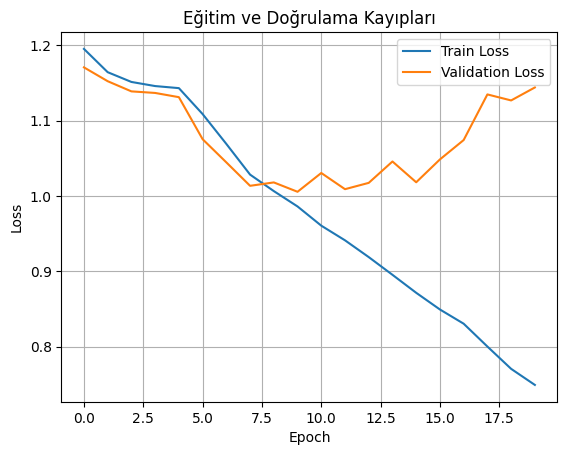

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Eğitim ve Doğrulama Kayıpları")
plt.grid(True)
plt.show()

model deneme

In [ ]:
from sklearn.metrics import classification_report

# Eğitilmiş model yükleniyor
model.load_state_dict(torch.load("densenet121_best_model.pth"))
model.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
import torch
import torchvision.models as models
import torch.nn as nn

num_classes = len(test_dataset.labels_list)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

densenet = models.densenet121(weights=None)

densenet.classifier = nn.Sequential(
    nn.Linear(densenet.classifier.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, num_classes)
)

densenet = densenet.to(device)

# 📥 Model yükle
densenet.load_state_dict(torch.load("densenet121_best_model.pth", map_location=device))
densenet.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve
import numpy as np

all_preds = []
all_targets = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.sigmoid(outputs).cpu().numpy()  # shape: [batch_size, num_classes]
        all_preds.append(preds)
        all_targets.append(labels.numpy())  # 👈 labels.numpy() olmalı

all_preds = np.concatenate(all_preds, axis=0)    # shape: [n_samples, n_classes]
all_targets = np.concatenate(all_targets, axis=0)

In [ ]:
from sklearn.metrics import precision_recall_curve
import numpy as np

optimal_thresholds = []
for i in range(all_targets.shape[1]):
    precision, recall, thresholds = precision_recall_curve(all_targets[:, i], all_preds[:, i])
    f1 = 2 * (precision[1:] * recall[1:]) / (precision[1:] + recall[1:] + 1e-8)
    best_thresh = thresholds[np.argmax(f1)]
    optimal_thresholds.append(best_thresh)

optimal_thresholds = np.array(optimal_thresholds)

# Binary prediction with optimal thresholds
binary_preds = (all_preds >= optimal_thresholds).astype(int)

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
import numpy as np

# AUC skorları
auc_scores = roc_auc_score(all_targets, all_preds, average=None)
mean_auc = roc_auc_score(all_targets, all_preds, average="macro")
micro_auc = roc_auc_score(all_targets, all_preds, average="micro")

# Sınıf isimleri
class_names = test_dataset.labels_list  # ya da train_dataset.labels_list

# Classification Report
report = classification_report(
    all_targets,
    binary_preds,
    target_names=class_names,
    zero_division=0
)

print("📊 Classification Report:")
print(report)

# Her sınıf için AUC yazdır
print("🔬 AUC Scores per Class:")
for cls, score in zip(class_names, auc_scores):
    print(f"{cls}: {score:.4f}")

# Subset Accuracy (exact match: tüm etiketler doğruysa 1)
subset_acc = accuracy_score(all_targets, binary_preds)

# Macro class-wise accuracy (her sınıfın doğruluk ortalaması)
macro_acc = (all_targets == binary_preds).mean(axis=0).mean()

print(f"\n✅ Subset Accuracy: {subset_acc:.4f}")
print(f"✅ Macro Class-wise Accuracy: {macro_acc:.4f}")

# Genel AUC skorları
print(f"\n📈 Macro AUC Score: {mean_auc:.4f}")
print(f"📈 Micro AUC Score: {micro_auc:.4f}")

📊 Classification Report:
                    precision    recall  f1-score   support

       Atelectasis       0.29      0.63      0.40       248
      Cardiomegaly       0.39      0.49      0.43        92
     Consolidation       0.24      0.66      0.35       155
             Edema       0.41      0.51      0.46       127
          Effusion       0.45      0.71      0.55       307
         Emphysema       0.65      0.51      0.57       115
          Fibrosis       0.22      0.37      0.28        97
      Infiltration       0.36      0.67      0.47       320
              Mass       0.25      0.54      0.34       178
        No Finding       0.44      0.65      0.52       277
            Nodule       0.22      0.50      0.30       159
Pleural_Thickening       0.17      0.68      0.27       140
         Pneumonia       0.24      0.41      0.30       107
      Pneumothorax       0.42      0.56      0.48       145

         micro avg       0.32      0.60      0.41      2467
         macr

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curves(y_true, y_score, class_names):
    plt.figure(figsize=(12, 10))
    for i in range(len(class_names)):
        try:
            fpr, tpr, _ = roc_curve(y_true[:, i], y_score[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')
        except ValueError:
            # Sadece tek sınıf varsa AUC hesaplanamaz
            print(f"ROC for class {class_names[i]} could not be calculated (only one class present).")

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves per Class')
    plt.legend(loc='lower right')
    plt.grid()
    plt.tight_layout()
    plt.show()

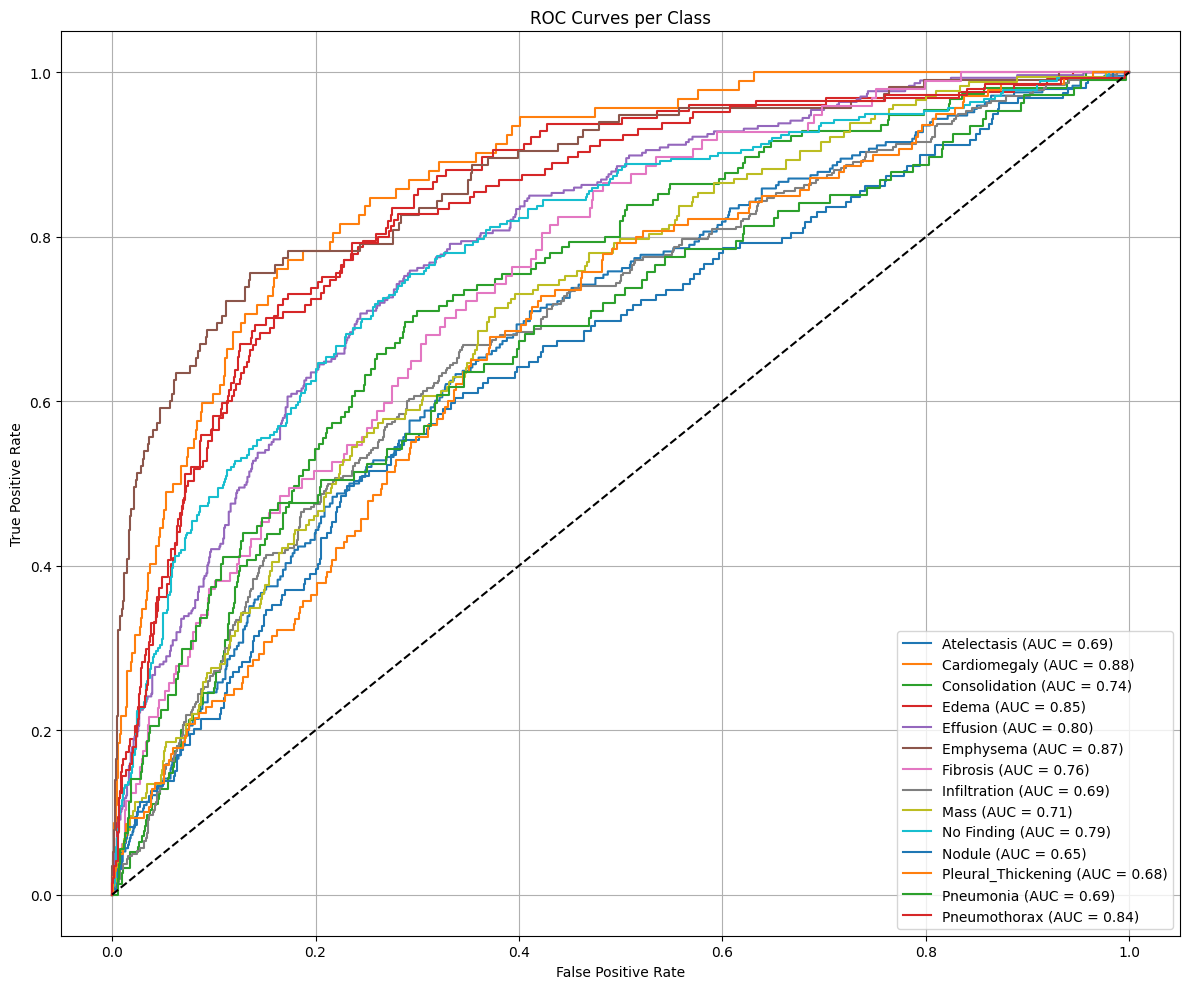

In [ ]:
# pred_probs = model(sigmoid çıkışları) → all_preds
# true_labels = gerçek etiketler → all_targets
# class_names = test_dataset.labels_list

plot_roc_curves(all_targets, all_preds, test_dataset.labels_list)

# ***VGG19 v2***

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

num_classes = len(train_dataset.labels_list)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg19 = models.vgg19(pretrained=True)

# Freeze feature extractor
for param in vgg19.features.parameters():
    param.requires_grad = False

# Custom classifier
vgg19.classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(4096, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, num_classes)
)

vgg19 = vgg19.to(device)

In [ ]:
# focal_loss.py gibi ayrı hücrede veya dosyada yer alabilir
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        probs = torch.sigmoid(inputs)
        probs = torch.clamp(probs, 1e-8, 1 - 1e-8)

        ce_loss = - (targets * torch.log(probs) + (1 - targets) * torch.log(1 - probs))
        pt = probs * targets + (1 - probs) * (1 - targets)

        if self.alpha is not None:
            ce_loss = self.alpha * ce_loss

        focal_loss = ((1 - pt) ** self.gamma) * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [ ]:
!rm -f torch.py
!rm -rf __pycache__/

In [ ]:
import torch.optim as optim
import numpy as np

# 🔢 Tüm etiketleri birleştir
all_labels = np.vstack([labels.numpy() for _, labels in train_loader])

# ✅ Pozitif ve negatif sayıları
pos_counts = all_labels.sum(axis=0)
neg_counts = all_labels.shape[0] - pos_counts

# 📏 Sınıf ağırlıkları → alpha (inverse freq.)
alpha = torch.tensor(neg_counts / (pos_counts + 1e-8), dtype=torch.float32).to(device)

# Focal Loss (gamma=2.0 önerilen)
criterion = FocalLoss(gamma=2.0, alpha=alpha)

# 🔧 Optimizer
optimizer = optim.Adam(vgg19.classifier.parameters(), lr=0.0005)

def train_epoch(model, loader, criterion, optimizer, device, accumulation_steps=16):
    model.train()
    running_loss = 0
    optimizer.zero_grad()

    for i, (images, labels) in enumerate(loader):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels) / accumulation_steps
        loss.backward()

        if (i + 1) % accumulation_steps == 0 or (i + 1 == len(loader)):
            optimizer.step()
            optimizer.zero_grad()

        running_loss += loss.item()

    return running_loss / len(loader)


def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

    return running_loss / len(loader)

AttributeError: partially initialized module 'torch._dynamo' has no attribute 'config' (most likely due to a circular import)

📊 Classification Report:
                    precision    recall  f1-score   support

       Atelectasis       0.27      0.59      0.37       248
      Cardiomegaly       0.28      0.32      0.30        92
     Consolidation       0.21      0.53      0.30       155
             Edema       0.32      0.49      0.39       127
          Effusion       0.42      0.60      0.49       307
         Emphysema       0.30      0.56      0.39       115
          Fibrosis       0.17      0.42      0.24        97
      Infiltration       0.31      0.67      0.42       320
              Mass       0.20      0.56      0.30       178
        No Finding       0.40      0.62      0.49       277
            Nodule       0.18      0.52      0.27       159
Pleural_Thickening       0.18      0.50      0.27       140
         Pneumonia       0.18      0.36      0.24       107
      Pneumothorax       0.34      0.48      0.39       145

         micro avg       0.27      0.55      0.36      2467
         macro avg       0.27      0.52      0.35      2467
      weighted avg       0.29      0.55      0.37      2467
       samples avg       0.29      0.53      0.34      2467

🔬 AUC Scores per Class:
Atelectasis: 0.6461
Cardiomegaly: 0.7438
Consolidation: 0.6914
Edema: 0.8116
Effusion: 0.7525
Emphysema: 0.7631
Fibrosis: 0.7009
Infiltration: 0.6473
Mass: 0.6539
No Finding: 0.7431
Nodule: 0.6446
Pleural_Thickening: 0.6490
Pneumonia: 0.6475
Pneumothorax: 0.7810

✅ Subset Accuracy: 0.0809
✅ Macro Class-wise Accuracy: 0.7562

📈 Macro AUC Score: 0.7054

📈 Micro AUC Score: 0.7375
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

In [ ]:
EPOCHS = 30
PATIENCE = 5
ACCUMULATION_STEPS = 16

best_val_loss = float('inf')
early_stop_counter = 0

for epoch in range(EPOCHS):
    train_loss = train_epoch(vgg19, train_loader, criterion, optimizer, device, ACCUMULATION_STEPS)
    val_loss = evaluate(vgg19, val_loader, criterion, device)

    print(f"Epoch [{epoch+1}/{EPOCHS}] - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(vgg19.state_dict(), "vgg19_best_multilabel.pth")
        print("✅ Best model saved.")
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        print(f"⏳ Early stopping patience: {early_stop_counter}/{PATIENCE}")

    if early_stop_counter >= PATIENCE:
        print("🛑 Early stopping triggered.")
        break

Epoch [1/30] - Train Loss: 0.0580, Val Loss: 0.7203
✅ Best model saved.
Epoch [2/30] - Train Loss: 0.0455, Val Loss: 0.6935
✅ Best model saved.
Epoch [3/30] - Train Loss: 0.0442, Val Loss: 0.6855
✅ Best model saved.
Epoch [4/30] - Train Loss: 0.0435, Val Loss: 0.6824
✅ Best model saved.
Epoch [5/30] - Train Loss: 0.0429, Val Loss: 0.6776
✅ Best model saved.
Epoch [6/30] - Train Loss: 0.0425, Val Loss: 0.6781
⏳ Early stopping patience: 1/5
Epoch [7/30] - Train Loss: 0.0421, Val Loss: 0.6790
⏳ Early stopping patience: 2/5
Epoch [8/30] - Train Loss: 0.0421, Val Loss: 0.6897
⏳ Early stopping patience: 3/5
Epoch [9/30] - Train Loss: 0.0418, Val Loss: 0.6681
✅ Best model saved.
Epoch [10/30] - Train Loss: 0.0415, Val Loss: 0.6692
⏳ Early stopping patience: 1/5
Epoch [11/30] - Train Loss: 0.0413, Val Loss: 0.6721
⏳ Early stopping patience: 2/5
Epoch [12/30] - Train Loss: 0.0412, Val Loss: 0.6676
✅ Best model saved.
Epoch [13/30] - Train Loss: 0.0410, Val Loss: 0.6691
⏳ Early stopping patience

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
import numpy as np

def test_model(model, loader, device):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            preds = torch.sigmoid(outputs).cpu().numpy()
            all_preds.append(preds)
            all_labels.append(labels.numpy())

    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)

    return all_preds, all_labels

# Modeli yükle
vgg19.load_state_dict(torch.load("vgg19_best_multilabel.pth", map_location=device))
vgg19.to(device)
vgg19.eval()

# Tahminleri al
pred_probs, true_labels = test_model(vgg19, test_loader, device)

In [ ]:
from sklearn.metrics import precision_recall_curve
import numpy as np

optimal_thresholds = []
for i in range(true_labels.shape[1]):
    precision, recall, thresholds = precision_recall_curve(true_labels[:, i], pred_probs[:, i])
    f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
    best_thresh = thresholds[np.argmax(f1)]
    optimal_thresholds.append(best_thresh)

optimal_thresholds = np.array(optimal_thresholds)

In [ ]:
# Binary sınıflandırma olduğu için threshold 0.5
binary_preds = (pred_probs >= optimal_thresholds).astype(int)

# AUC skorları
auc_scores = roc_auc_score(true_labels, pred_probs, average=None)
mean_auc = roc_auc_score(true_labels, pred_probs, average="macro")
micro_auc = roc_auc_score(true_labels, pred_probs, average="micro")

# Sınıf isimleri
class_names = train_dataset.labels_list

# Classification report
report = classification_report(true_labels, binary_preds, target_names=class_names)

print("📊 Classification Report:")
print(report)

print("🔬 AUC Scores per Class:")
for cls, score in zip(class_names, auc_scores):
    print(f"{cls}: {score:.4f}")

subset_acc = accuracy_score(true_labels, binary_preds)
macro_acc = (true_labels == binary_preds).mean(axis=0).mean()
print(f"\n✅ Subset Accuracy: {subset_acc:.4f}")
print(f"✅ Macro Class-wise Accuracy: {macro_acc:.4f}")


print(f"\n📈 Macro AUC Score: {mean_auc:.4f}")
print(f"\n📈 Micro AUC Score: {micro_auc:.4f}")

📊 Classification Report:
                    precision    recall  f1-score   support

       Atelectasis       0.27      0.59      0.37       248
      Cardiomegaly       0.28      0.32      0.30        92
     Consolidation       0.21      0.53      0.30       155
             Edema       0.32      0.49      0.39       127
          Effusion       0.42      0.60      0.49       307
         Emphysema       0.30      0.56      0.39       115
          Fibrosis       0.17      0.42      0.24        97
      Infiltration       0.31      0.67      0.42       320
              Mass       0.20      0.56      0.30       178
        No Finding       0.40      0.62      0.49       277
            Nodule       0.18      0.52      0.27       159
Pleural_Thickening       0.18      0.50      0.27       140
         Pneumonia       0.18      0.36      0.24       107
      Pneumothorax       0.34      0.48      0.39       145

         micro avg       0.27      0.55      0.36      2467
         macr

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


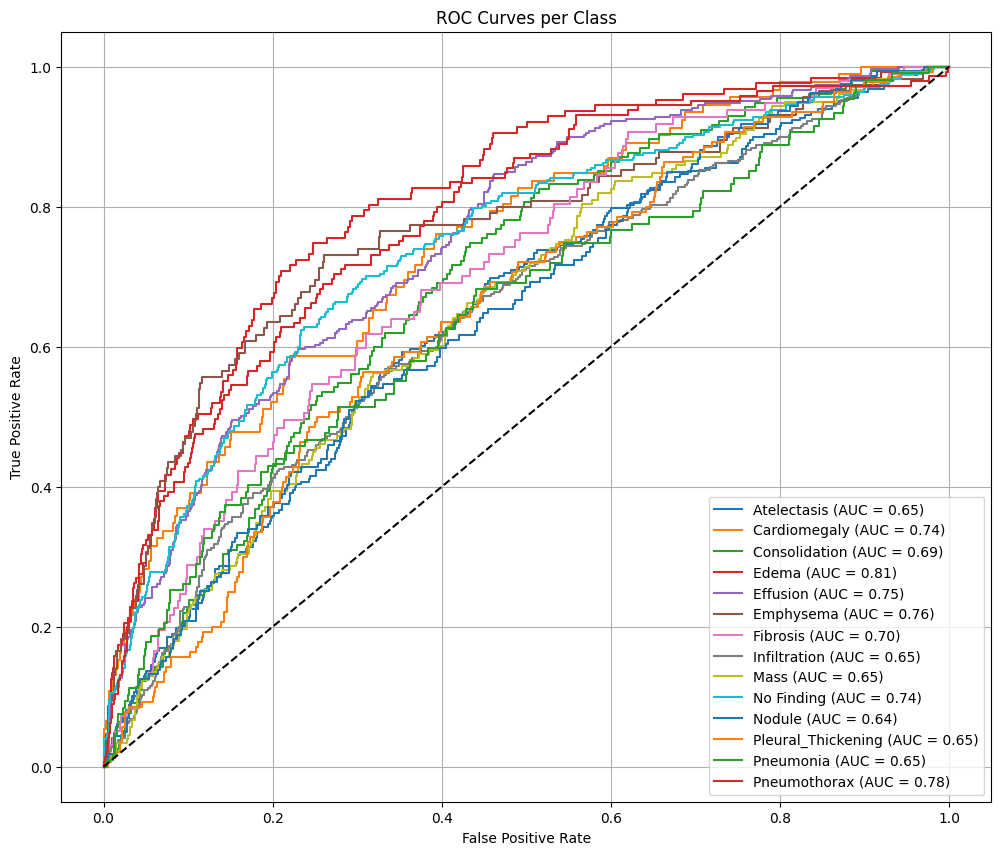

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curves(y_true, y_score, class_names):
    plt.figure(figsize=(12, 10))
    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves per Class')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

# ROC çizimi
plot_roc_curves(true_labels, pred_probs, class_names)